In [5]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

In [2]:
xl = pd.ExcelFile('ucy_eko_data.xlsx')
print(xl.sheet_names)
xl.close()

['smile_customers', 'smile_sales']


In [6]:
customers, sales = pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_customers'), pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_sales')

In [4]:
customers['accreccreateddate'] = pd.to_datetime(customers['accreccreateddate'])
customers = customers.set_index('accreccreateddate')
customers.sort_index(inplace=True)

In [8]:
sales['receiptdate'] = pd.to_datetime(sales['receiptdate'])
sales = sales.set_index('receiptdate')
sales.sort_index(inplace=True)

In [6]:
activity = sales.reset_index()\
        .drop_duplicates('receiptdate')\
            .sort_values(['ciid', 'receiptdate'])\
                .groupby('ciid')\
                    .agg(
                        min_receiptdate = pd.NamedAgg(column='receiptdate', aggfunc=pd.Series.min),
                        max_receiptdate = pd.NamedAgg(column='receiptdate', aggfunc=pd.Series.max)
                    )
activity.head()

,min_receiptdate,max_receiptdate
ciid,,
0000036BDF374B1986DD6F0B4E89227D,2021-02-27 07:55:57,2022-09-29 11:14:30
0000571B6BDB4EAE80203D6794F17298,2021-07-24 12:12:54,2023-06-23 13:18:51
0000836B5AC84ABCB593598016DB0B23,2020-10-21 10:25:24,2023-04-20 14:35:54
000096A56FBC4DE68D63E3A161263F23,2020-09-17 10:32:09,2023-05-08 08:51:12
00035E6633D84A40B97F593D4EA64481,2022-01-17 08:58:32,2022-04-29 09:52:36


In [7]:
activity['lifecyclestate_new'] = activity['max_receiptdate'].apply(
    lambda x: 'active' if x.year == 2023 and x.month == 6 else \
                'semi-active' if x.year == 2023 and x.month == 5 else 'churn'
)

In [8]:
activity['lifecyclestate_new'].value_counts(normalize=True)

active         0.464281
churn          0.434189
semi-active    0.101531
Name: lifecyclestate_new, dtype: float64

In [9]:
activity['tenure'] = activity.apply(
    lambda x: (x['max_receiptdate'] - x['min_receiptdate']).days,
    axis=1
)

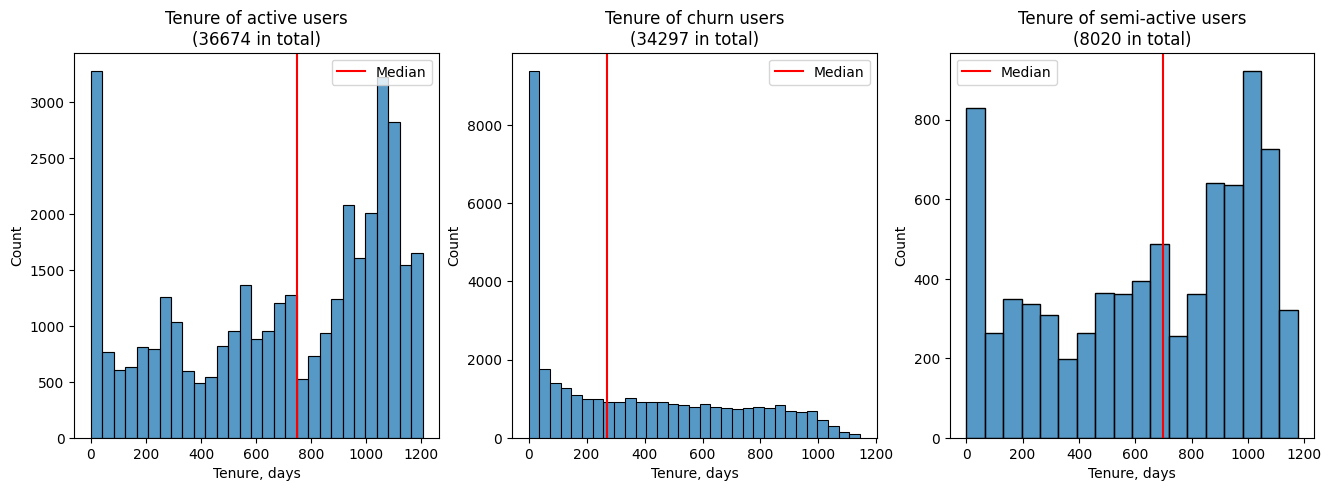

In [10]:
matplotlib.rcParams['figure.figsize'] = (16, 5)
fig, axes = plt.subplots(nrows=1, ncols=3)
for idx, category in enumerate(
    sorted(activity['lifecyclestate_new'].unique())
):
    df_chart = activity.query(f'lifecyclestate_new == "{category}"')
    sns.histplot(
        df_chart['tenure'],
        bins='fd',
        ax=axes[idx]
    )
    axes[idx].set_title(f'Tenure of {category} users\n({df_chart.shape[0]} in total)')
    axes[idx].set_xlabel('Tenure, days')
    axes[idx].axvline(df_chart['tenure'].median(), color='r')
    axes[idx].legend(labels=['Median'])

In [11]:
hours = pd.DataFrame(
    data = sales.reset_index()\
        .drop_duplicates(['ciid', 'receiptdate'])\
            .sort_values(['ciid', 'receiptdate'])\
                .groupby('ciid')\
                    .agg(receiptdate_diff = pd.NamedAgg(column='receiptdate', aggfunc=pd.Series.diff))\
                        .apply(lambda x: np.floor(x['receiptdate_diff'] / np.timedelta64(1, 'h')), axis=1),
    columns = ['receiptdate_diff_hours']
)
hours = hours.explode('receiptdate_diff_hours')
hours.head()

,receiptdate_diff_hours
ciid,
0000036BDF374B1986DD6F0B4E89227D,NaN
0000036BDF374B1986DD6F0B4E89227D,167.0
0000036BDF374B1986DD6F0B4E89227D,1970.0
0000036BDF374B1986DD6F0B4E89227D,2205.0
0000036BDF374B1986DD6F0B4E89227D,2447.0


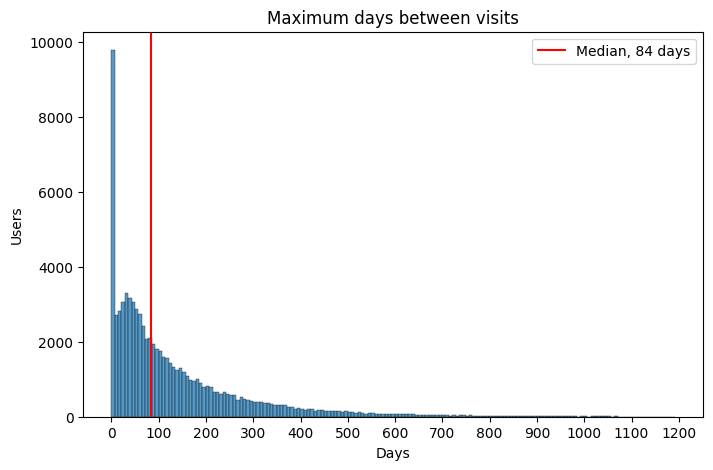

In [12]:
matplotlib.rcParams['figure.figsize'] = (8, 5)
df_chart = hours['receiptdate_diff_hours'].div(24, fill_value=0).to_frame('receiptdate_diff_days')
df_chart = df_chart.groupby(df_chart.index)['receiptdate_diff_days'].max()
fig, ax = plt.subplots()
sns.histplot(df_chart, ax=ax)
ax.set_title("Maximum days between visits")
ax.set_xlabel('Days')
ax.set_xticks([i for i in range(0, 1300, 100)])
ax.set_ylabel('Users')
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.axvline(df_chart.median(), color='r')
ax.legend(labels=[f'Median, {"%.f" % df_chart.median()} days'])
plt.show()

In [13]:
def visits_after_max_break(s):
    '''
    Method to find the share of visits, being made after the visit, which occured after the longest break (not including)
    '''
    idx_max = list(s.index).index(s.idxmax())
    return 1-((idx_max+1)/s.shape[0])

hours = hours.astype({'receiptdate_diff_hours': 'float64'})
purchases = hours.fillna(0).reset_index().groupby('ciid')['receiptdate_diff_hours'].apply(visits_after_max_break).to_frame('visits_share_after_max_break')

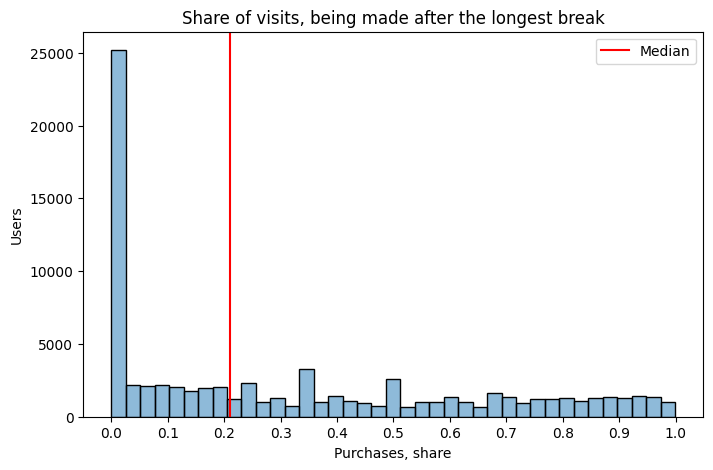

In [14]:
# Purchase here is defined by a single date, i.e., not considering multiple transactions mapped to a single datetime value
fig, ax = plt.subplots()
sns.histplot(purchases, bins='scott', ax=ax)
ax.set_title('Share of visits, being made after the longest break')
ax.set_xlabel('Purchases, share')
ax.set_ylabel('Users')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.axvline(purchases['visits_share_after_max_break'].median(), color='r')
ax.legend(labels=['Median'])
plt.show()

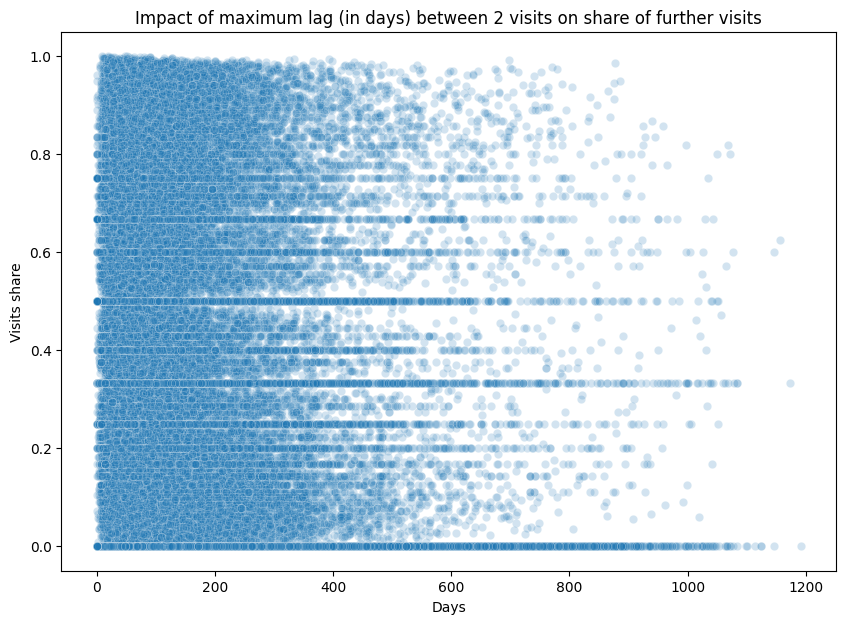

In [15]:
matplotlib.rcParams['figure.figsize'] = (10, 7)
df_corr = pd.merge(
    purchases.reset_index(),
    df_chart.to_frame().reset_index(),
    on='ciid',
    how='left'
)
fig, ax = plt.subplots()
sns.scatterplot(y='visits_share_after_max_break', x='receiptdate_diff_days', data=df_corr, alpha=0.2, ax=ax)
ax.set_title('Impact of maximum lag (in days) between 2 visits on share of further visits')
ax.set_xlabel('Days')
ax.set_ylabel('Visits share')
plt.show()

In [16]:
from scipy.stats import spearmanr
spearmanr(df_corr['visits_share_after_max_break'], df_corr['receiptdate_diff_days'])

SpearmanrResult(correlation=0.170434556974569, pvalue=0.0)

## Covid impact analysis

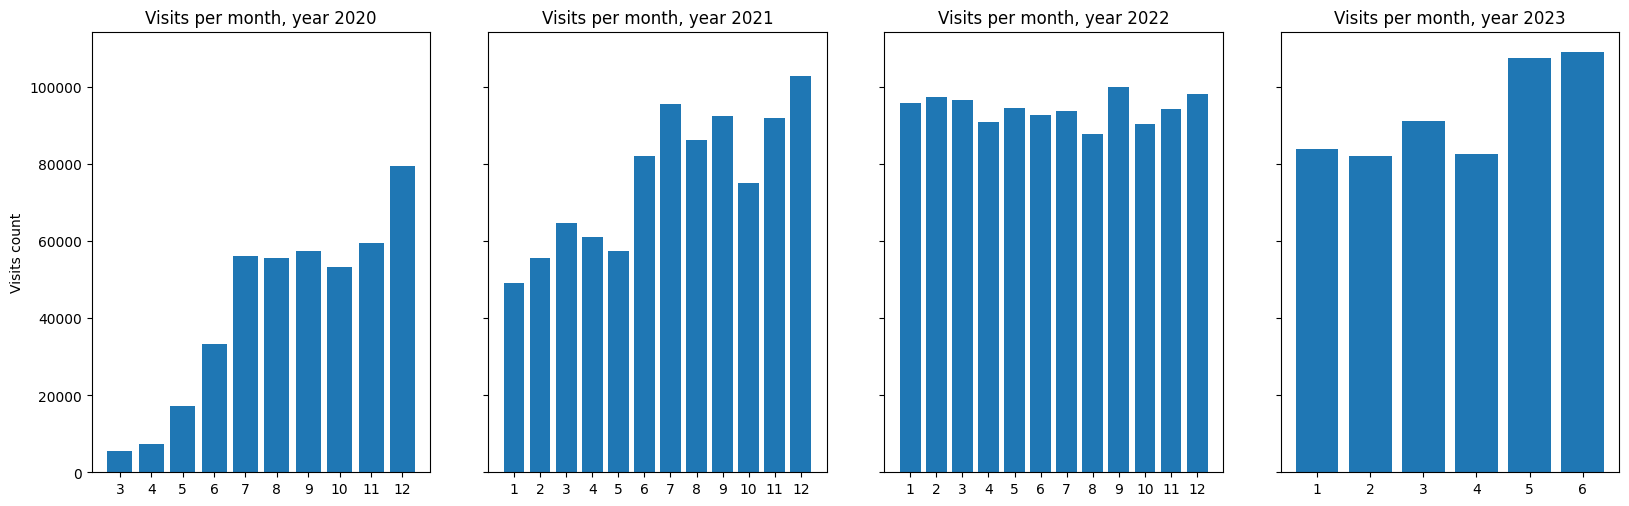

In [17]:
matplotlib.rcParams['figure.figsize'] = (16, 5)
df_chart = sales.reset_index().drop_duplicates(['ciid', 'receiptdate'])\
    .groupby(
        [
            sales.reset_index().drop_duplicates(['ciid', 'receiptdate']).set_index('receiptdate').index.year,
            sales.reset_index().drop_duplicates(['ciid', 'receiptdate']).set_index('receiptdate').index.month
        ]
    )\
    .agg(
        visits_count = pd.NamedAgg('receiptid', 'count')
    )
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.tight_layout()
for idx, year in enumerate(df_chart.index.get_level_values(0).unique()):
    df_chart_cut = df_chart[df_chart.index.get_level_values(0)==year]
    ax[idx].bar(height=df_chart_cut['visits_count'], x=df_chart_cut.index.get_level_values(1))
    ax[idx].set_title(f'Visits per month, year {year}')
    ax[idx].set_ylim([0, df_chart['visits_count'].max()*1.05])
    ax[idx].set_xticks(df_chart_cut.index.get_level_values(1))
    if idx==0:
        ax[idx].set_ylabel('Visits count')
    else:
        ax[idx].set_yticklabels([''])
plt.show()

In [18]:
hours_cut = pd.DataFrame(
    data = sales[
        sales.index >= datetime(2021, 6, 1, 0, 0, 0)
    ].reset_index()\
        .drop_duplicates(['ciid', 'receiptdate'])\
            .sort_values(['ciid', 'receiptdate'])\
                .groupby('ciid')\
                    .agg(receiptdate_diff = pd.NamedAgg(column='receiptdate', aggfunc=pd.Series.diff))\
                        .apply(lambda x: np.floor(x['receiptdate_diff'] / np.timedelta64(1, 'h')), axis=1),
    columns = ['receiptdate_diff_hours']
)
hours_cut = hours_cut.explode('receiptdate_diff_hours')
hours_cut.head()

,receiptdate_diff_hours
ciid,
0000036BDF374B1986DD6F0B4E89227D,NaN
0000036BDF374B1986DD6F0B4E89227D,2447.0
0000036BDF374B1986DD6F0B4E89227D,71.0
0000036BDF374B1986DD6F0B4E89227D,26.0
0000036BDF374B1986DD6F0B4E89227D,4533.0


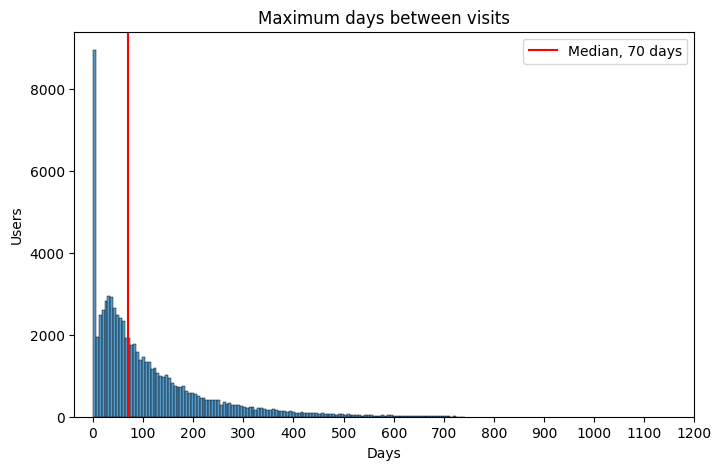

In [19]:
matplotlib.rcParams['figure.figsize'] = (8, 5)
df_chart = hours_cut['receiptdate_diff_hours'].div(24, fill_value=0).to_frame('receiptdate_diff_days')
df_chart = df_chart.groupby(df_chart.index)['receiptdate_diff_days'].max()
fig, ax = plt.subplots()
sns.histplot(df_chart, ax=ax)
ax.set_title("Maximum days between visits")
ax.set_xlabel('Days')
ax.set_xticks([i for i in range(0, 1300, 100)])
ax.set_ylabel('Users')
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.axvline(df_chart.median(), color='r')
ax.legend(labels=[f'Median, {"%.f" % df_chart.median()} days'])
plt.show()

In [20]:
hours_cut = hours_cut.astype({'receiptdate_diff_hours': 'float64'})
purchases_cut = hours_cut.fillna(0).reset_index().groupby('ciid')['receiptdate_diff_hours'].apply(visits_after_max_break).to_frame('visits_share_after_max_break')

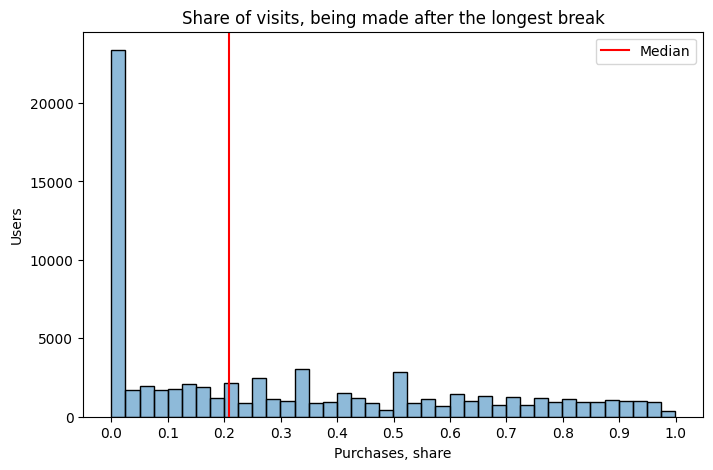

In [21]:
# Purchase here is defined by a single date, i.e., not considering multiple transactions mapped to a single datetime value
fig, ax = plt.subplots()
sns.histplot(purchases_cut, bins='scott', ax=ax)
ax.set_title('Share of visits, being made after the longest break')
ax.set_xlabel('Purchases, share')
ax.set_ylabel('Users')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.axvline(purchases_cut['visits_share_after_max_break'].median(), color='r')
ax.legend(labels=['Median'])
plt.show()

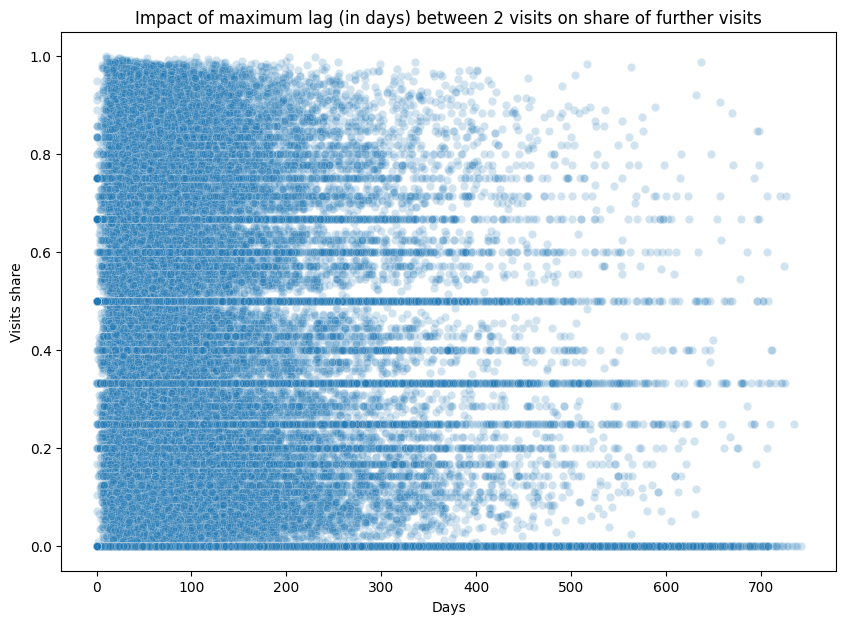

In [22]:
matplotlib.rcParams['figure.figsize'] = (10, 7)
df_corr = pd.merge(
    purchases_cut.reset_index(),
    df_chart.to_frame().reset_index(),
    on='ciid',
    how='left'
)
fig, ax = plt.subplots()
sns.scatterplot(y='visits_share_after_max_break', x='receiptdate_diff_days', data=df_corr, alpha=0.2, ax=ax)
ax.set_title('Impact of maximum lag (in days) between 2 visits on share of further visits')
ax.set_xlabel('Days')
ax.set_ylabel('Visits share')
plt.show()

In [23]:
from scipy.stats import spearmanr
spearmanr(df_corr['visits_share_after_max_break'], df_corr['receiptdate_diff_days'])

SpearmanrResult(correlation=0.15618713284010347, pvalue=0.0)

In [11]:
sales['receiptdate_cut'] = sales.index.to_period('D')
months = sales[
        sales.index >= datetime(2021, 6, 1, 0, 0, 0)
    ].reset_index().drop_duplicates(['ciid', 'receiptdate_cut']).sort_values('receiptdate_cut')\
            .set_index('receiptdate_cut')\
                .groupby('ciid')\
                    .rolling(timedelta(days=30))\
                        ['receiptid'].count()\
                            .groupby(['ciid', 'receiptdate_cut']).sum()\
                                .to_frame('visits_count').reset_index()
first_dates = months.groupby('ciid')['receiptdate_cut'].first()
months['months_enum'] = (
                            months['receiptdate_cut'] - months['ciid'].map(first_dates)
                        ) / np.timedelta64(1, 'M')
months['months_enum'] = np.add(months['months_enum'], 1).apply(np.float64).apply(np.round).fillna(1.0)
months.head()

,ciid,receiptdate_cut,visits_count,months_enum
0,0000036BDF374B1986DD6F0B4E89227D,2021-08-27,1.0,1.0
1,0000036BDF374B1986DD6F0B4E89227D,2021-12-07,1.0,4.0
2,0000036BDF374B1986DD6F0B4E89227D,2021-12-10,2.0,4.0
3,0000036BDF374B1986DD6F0B4E89227D,2021-12-11,3.0,4.0
4,0000036BDF374B1986DD6F0B4E89227D,2022-06-18,1.0,11.0


In [12]:
df_chart = months.reset_index().set_index('months_enum')\
    .groupby('ciid')\
        .agg(month_max_visits = pd.NamedAgg('visits_count', pd.Series.idxmax))\
            .reset_index().groupby('month_max_visits')\
                .agg(max_visits_count = pd.NamedAgg('ciid', 'count'))
df_chart.head()

,max_visits_count
month_max_visits,
1.0,19053
2.0,16046
3.0,6157
4.0,4044
5.0,3031


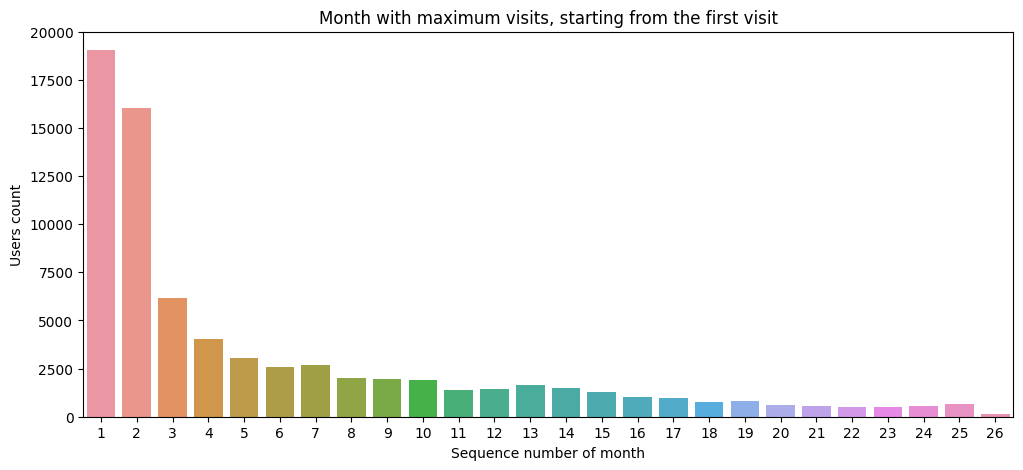

In [13]:
matplotlib.rcParams['figure.figsize'] = (12, 5)
fig, ax = plt.subplots()
sns.barplot(x=df_chart.index.astype(int), y=df_chart['max_visits_count'], ax=ax)
ax.set_title('Month with maximum visits, starting from the first visit')
ax.set_xlabel('Sequence number of month')
ax.set_ylabel('Users count')
plt.show()

In [14]:
months['next_month'] = months['months_enum'].shift(-1).replace(1.0, np.NaN)
months['transition'] = months.apply(lambda x: f"{x['months_enum']}-{x['next_month']}", axis=1)

In [15]:
def find_consecutive_months(s):
    return s[(s.diff().gt(1).cumsum()+1)==1].index

In [16]:
consec_months = months.query('next_month <= 12').groupby('ciid')['months_enum'].apply(find_consecutive_months)
consec_months_idx = [i[j] for i in consec_months for j in range(len(i))]

In [17]:
df_chart = months.loc[consec_months_idx, :]
df_chart = df_chart.groupby(['months_enum', 'next_month'])\
    .agg(users_count = pd.NamedAgg('ciid', 'count'))\
        .groupby('months_enum').first()
df_chart.index = df_chart.index+1
df_chart = df_chart.append(
    pd.DataFrame(
        index=pd.Index(data=[1], name='months_enum'),
        data=[months['ciid'].unique().shape[0]],
        columns=['users_count']
    )
)
df_chart.sort_index(inplace=True)

funnel_chart = px.funnel(
    data_frame=df_chart,
    x='users_count',
    y=df_chart.index,
    orientation='h',
    width=800,
    height=600,
    title='Transition of users through consecutive months of gas station visits',
    labels={
        'months_enum': 'Month of app usage'
    }
)
funnel_chart.update_xaxes(autorange="reversed", row=1, col=1)
funnel_chart.update_layout(
    yaxis={'tick0': 1, 'dtick': 1}
)
funnel_chart.show()

df_chart

,users_count
months_enum,
1.0,73895
2.0,45904
3.0,90656
4.0,75768
5.0,65441
6.0,54980
7.0,54229
8.0,50330
9.0,43189
